In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
class EarthquakeDataset(Dataset):
    def __init__(self, data_csv, features_csv, feature_list):
        self.data_frame = data_csv
        self.features_frame = features_csv
        epsilon = 1e-7
        # Extract feature data from the features DataFrame
        #self.feature_data = self.features_frame[feature_list].values
        #np.where(np.isnan(self.features_frame[feature_list].values) | (self.features_frame[feature_list].values < 0), 0, self.features_frame[feature_list].values)
        self.feature_data = np.log10(np.where(np.isnan(self.features_frame[feature_list].values) | (self.features_frame[feature_list].values < 0), 0, self.features_frame[feature_list].values) + epsilon)

        # Extract target labels
        self.labels = np.log10(np.nan_to_num(self.features_frame[[' PGA ', ' PGV ', ' tPGA ', ' tPGV ']].values, nan=0.0) + epsilon)

        # Convert strings to matrices
        self.features = self.preprocess(self.data_frame)

    def preprocess(self, df):
        # Initialize list to hold processed matrices
        matrices = []
        # For each row in the DataFrame...
        for _, row in df.iterrows():
            # Convert cell to NP array and stack vertically
            matrix = np.vstack([np.array(list(map(float, str(row[col]).split()))) for col in df.columns])
            matrices.append(matrix)
        return matrices

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Convert to torch tensors
        matrix = torch.tensor(self.features[idx], dtype=torch.float32)
        feature_vector = torch.tensor(self.feature_data[idx], dtype=torch.float32)
        # Combine matrix with feature vectors horizontally
        combined_matrix = [matrix, feature_vector]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return combined_matrix, label

In [ ]:
data_csv = "/content/drive/MyDrive/Data/EEWS/EEW_P_wave_data_2024-04-12.csv"
features_csv = "/content/drive/MyDrive/Data/EEWS/EEW_features_2024-04-12.csv"
feature_list = [' pkev12 ', ' pkev23 ', ' durP ', ' tauPd ', ' tauPt ',
       ' PDd ', ' PVd ', ' PAd ', ' PDt ', ' PVt ', ' PAt ', ' ddt_PDd ',
               ' ddt_PVd ', ' ddt_PAd ']
data_df = pd.read_csv(data_csv)
features_df = pd.read_csv(features_csv)

# train test split
train_data_df, test_data_df, train_features_df, test_features_df = train_test_split(
    data_df, features_df, test_size=0.2, random_state=42
)

train_dataset = EarthquakeDataset(train_data_df, train_features_df, feature_list)
test_dataset = EarthquakeDataset(test_data_df, test_features_df, feature_list)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class Earthquake_Magnitude_Predictor(nn.Module):
    def __init__(self):
        super(Earthquake_Magnitude_Predictor, self).__init__()
        # Convolutional L1 followed by BatchNorm and MaxPool
        self.conv1 = nn.Conv1d(in_channels=9, out_channels=32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=3)  # Using the same MaxPool for all conv layers
        # # Convolutional L2 followed by BatchNorm and MaxPool
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)


        self.fc1 = nn.Linear(3556 + len(feature_list), 2058)
        self.fc2 = nn.Linear(2058, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.final = nn.Linear(512, 4)

    def extract_stats_for_batch(self, tensor):
      """
        Extracts the min, max, mean, and variance of each 1 by 500 tensor within each 9 by 500 tensor in a batch.
        The input tensor shape is expected to be [batch_size, 1, 9, 500]. Returns a batch_size by 36 tensor, where each row contains the flattened values of the min, max, mean,
      and variance for each row in the 9 by 500 tensor.
      """
      stats_tensor = torch.zeros(tensor.size(0), 36)
      for i, t in enumerate(tensor):
          # reshape [1, 9, 500] tensor to [9, 500]
          reshaped_t = t.squeeze(0)
          stats = {
              "min": reshaped_t.min(dim=1).values,
              "max": reshaped_t.max(dim=1).values,
              "mean": reshaped_t.mean(dim=1),
              "variance": reshaped_t.var(dim=1, unbiased=False)  # unbiased=False -> sample variance
          }
          # flatten
          stats_tensor[i] = torch.cat((stats["min"], stats["max"], stats["mean"], stats["variance"]))
      return stats_tensor


    def forward(self, raw_waveform, features):
        batch_stats = self.extract_stats_for_batch(raw_waveform)
        x = self.pool(F.relu(self.conv1(raw_waveform)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.cat((x, batch_stats.to(device)), dim=1)
        x = torch.cat((x, features.to(device)), dim=1)
        #positional embedding: but very simplistic due to d_model being only 1 (we do not embed this into a higher dimension like in NLP)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.final(x)
        return x

# Evaluation Function
def evaluate_model(model, dataloader):
    model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for data, target in dataloader:
            seq_matrix = data[0]
            features = data[1]
            seq_matrix = seq_matrix.float().to(device)  # Add channel dimension
            target = target.float().to(device)
            output = model(seq_matrix, features)
            all_outputs.append(output)
            all_targets.append(target)

    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    return all_outputs, all_targets

epoch:  0 loss 27.31411361694336
epoch:  1 loss 244.87705993652344
epoch:  2 loss 5.334954738616943
epoch:  3 loss 1.2342740297317505
epoch:  4 loss 42.70518112182617
epoch:  5 loss 6020.67138671875
epoch:  6 loss 57.553951263427734
epoch:  7 loss 3.452944755554199
epoch:  8 loss 7.157089710235596
epoch:  9 loss 1.7881720066070557
epoch:  10 loss 2.385225534439087
epoch:  11 loss 1.2870643138885498
epoch:  12 loss 0.26566749811172485
epoch:  13 loss 0.46407148241996765
epoch:  14 loss 1.601997971534729
epoch:  15 loss 0.34962356090545654
epoch:  16 loss 0.23602895438671112
epoch:  17 loss 2.7198495864868164
epoch:  18 loss 0.17817148566246033
epoch:  19 loss 0.06325843930244446
epoch:  20 loss 0.13545377552509308
epoch:  21 loss 0.11268241703510284
epoch:  22 loss 0.7689813375473022
epoch:  23 loss 0.0965900719165802
epoch:  24 loss 0.14462636411190033
epoch:  25 loss 0.19129621982574463
epoch:  26 loss 2.572998285293579
epoch:  27 loss 0.555241048336029
epoch:  28 loss 0.1186201348900

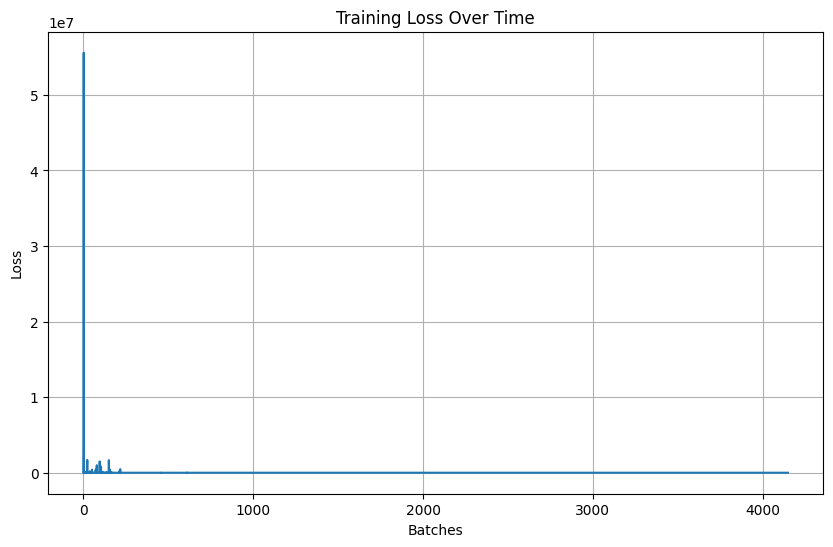

In [ ]:
# Model, Loss, and Optimizer
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Earthquake_Magnitude_Predictor()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
for epoch in range(50):
    for data, target in train_loader:
        seq_matrix = data[0]
        features = data[1]
        seq_matrix = seq_matrix.float().to(device)  # Add channel dimension
        target = target.float().to(device)
        optimizer.zero_grad()
        output = model(seq_matrix, features)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print('epoch: ', epoch, 'loss', loss.item())

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import r2_score

predictions, actuals = evaluate_model(model, test_loader)

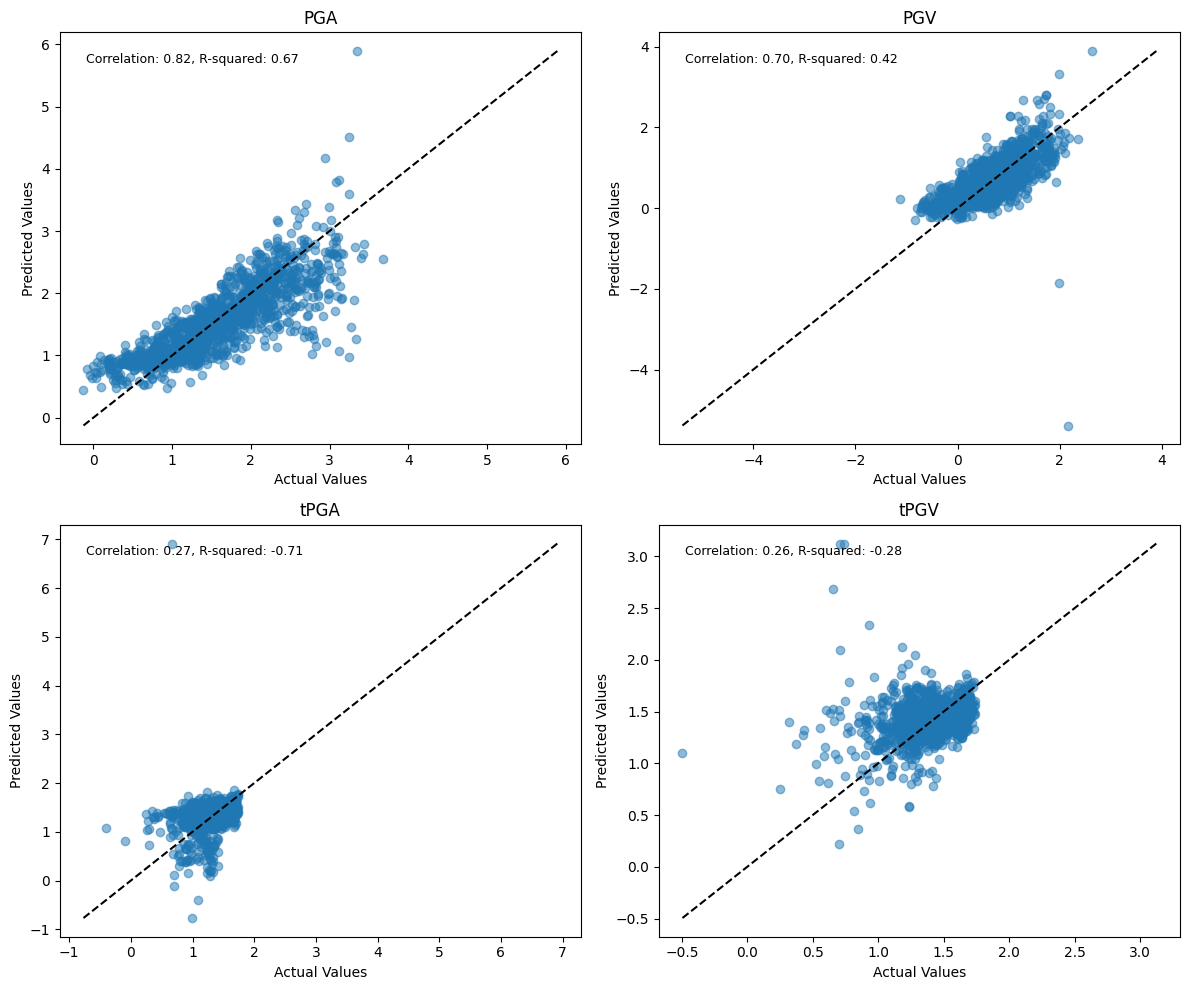

In [ ]:
labels = ['PGA', 'PGV', 'tPGA', 'tPGV']
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, label in enumerate(labels):
    prediction = predictions[:, i].cpu().numpy()
    actual = actuals[:, i].cpu().numpy()
    correlation = np.corrcoef(prediction, actual)[0, 1]
    r_squared = r2_score(actual, prediction)
    min_val = min(min(actual), min(prediction))
    max_val = max(max(actual), max(prediction))

    axs[i].scatter(actual, prediction, alpha=0.5)
    axs[i].plot([min_val, max_val], [min_val, max_val], 'k--')
    text_str = f'Correlation: {correlation:.2f}, R-squared: {r_squared:.2f}'
    axs[i].text(0.05, 0.95, text_str, transform=axs[i].transAxes, fontsize=9, verticalalignment='top')

    axs[i].set_xlabel('Actual Values')
    axs[i].set_ylabel('Predicted Values')
    axs[i].set_title(label)

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/EEWS/model1.pth')